In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


In [ ]:
df   = pd.read_csv('airbnb_Chicago.csv')

In [3]:
df.head()

,Airbnb Host ID,Airbnb Property ID,City_x,superhost_period_all,scrapes_in_period,Scraped Date,superhost_observed_in_period,host_is_superhost_in_period,superhost_ratio,prev_superhost_period_all,...,prev_host_is_superhost2,prev_year_superhosts,booked_days_period_city,revenue_period_city,booked_days_period_tract,revenue_period_tract,tract_booking_share,tract_revenue_share,time_to_date_mean,prev_time_to_date_mean
0,2153.0,1947.0,Chicago,13.0,15.0,2018-08-05,15.0,0.0,0.0,12.0,...,0.0,0.0,156228.0,19897074.0,670.0,116221.0,0.004289,0.005841,NaN,NaN
1,2153.0,1947.0,Chicago,15.0,14.0,2019-02-12,14.0,0.0,0.0,14.0,...,0.0,0.0,196160.0,25150438.0,620.0,153879.0,0.003161,0.006118,NaN,NaN
2,2153.0,1947.0,Chicago,18.0,28.0,2019-11-05,28.0,1.0,1.0,17.0,...,0.0,0.0,102926.0,11179243.0,812.0,81472.0,0.007889,0.007288,NaN,NaN
3,2153.0,1947.0,Chicago,19.0,41.0,2020-02-02,41.0,0.0,0.0,18.0,...,0.0,1.0,93167.0,11565335.0,582.0,71458.0,0.006247,0.006179,NaN,NaN
4,2153.0,1947.0,Chicago,20.0,33.0,2020-05-01,33.0,0.0,0.0,19.0,...,0.0,1.0,92329.0,12319266.0,641.0,89729.0,0.006943,0.007284,NaN,NaN


## Handling Missing Values

In [4]:
missing_summary = df.isnull().sum().sort_values(ascending=False)
missing_summary[missing_summary > 0]


Integrated Property Manager                         120217
prev_time_to_date_mean                               44631
prev_booked_days_avePrice                            40294
prev_booked_days                                     40294
prev_occupancy_rate                                  40294
prev_revenue                                         40294
time_to_date_mean                                    38108
booked_days_avePrice                                 38108
booked_days                                          38108
occupancy_rate                                       38108
revenue                                              38108
prev_rating_ave_pastYear                             29172
prev_prop_5_StarReviews_pastYear                     29172
prev_num_5_star_Rev_pastYear                         28296
prev_numReviews_pastYear                             28296
prev_numCancel_pastYear                              28296
prev_Rating Overall                                  257

In [5]:
# removing the missing value rows from the columns that have less than 20 missing records
df = df.dropna(subset=[
    'Number of Reviews', 'Bedrooms', 'Max Guests',
    'Number of Photos', 'Minimum Stay',
    'Property Type', 'Property Type.1'
])
df.shape


(120170, 111)

In [6]:
missing_summary = df.isnull().sum().sort_values(ascending=False)
missing_summary[missing_summary > 0]

Integrated Property Manager                         120170
prev_time_to_date_mean                               44589
prev_revenue                                         40259
prev_booked_days_avePrice                            40259
prev_booked_days                                     40259
prev_occupancy_rate                                  40259
occupancy_rate                                       38091
time_to_date_mean                                    38091
revenue                                              38091
booked_days                                          38091
booked_days_avePrice                                 38091
prev_rating_ave_pastYear                             29158
prev_prop_5_StarReviews_pastYear                     29158
prev_num_5_star_Rev_pastYear                         28282
prev_numReviews_pastYear                             28282
prev_numCancel_pastYear                              28282
prev_Rating Overall                                  257

In [7]:
# Check if the two columns are the same
df[['Property Type', 'Property Type.1']].drop_duplicates()


,Property Type,Property Type.1
0,Apartment,Apartment
5,Condominium,Condominium
121,Loft,Loft
130,Room in boutique hotel,Room in boutique hotel
258,House,House
...,...,...
94640,Earth house,Earth house
102614,Home/apt,Home/apt
111284,Dome house,Dome house
112994,Campsite,Campsite


In [8]:
df = df.drop(columns=['Property Type.1'])


In [9]:
# Convert to datetime format
df['Scraped Date'] = pd.to_datetime(df['Scraped Date'], errors='coerce')
df['Created Date'] = pd.to_datetime(df['Created Date'], errors='coerce')


### before further handing of missing values - Select all the important features

In [10]:
# List of selected features for modeling
selected_features = [
    # Target
    'host_is_superhost_in_period',
    
    # Superhost history
    'prev_host_is_superhost_in_period',
    
    # Review metrics
    'rating_ave_pastYear', 'numReviews_pastYear',
    'numCancel_pastYear', 'num_5_star_Rev_pastYear',
    'prop_5_StarReviews_pastYear', 'occupancy_rate','revenue',
    
    # Reservation activity
    'numReserv_pastYear', 'numReservedDays_pastYear',
    
    # Host responsiveness
    'Instantbook Enabled',
    'hostResponseAverage_pastYear', 'hostResponseNumber_pastYear',
    
    # Listing details
    'Listing Type', 'Property Type', 'Bedrooms', 'Bathrooms',
    'Cleaning Fee (USD)', 'Number of Photos', 'Minimum Stay',
    'Max Guests', 'Nightly Rate',
    'Created Date',
    
    # Neighborhood/census features
    'Neighborhood', 'Zipcode',
    'tract_superhosts_ratio', 'tract_price_variance',
    'Nightly Rate_tractQuartile'
]

# Add Host ID for grouping purposes
selected_features_with_id = ['Airbnb Host ID'] + selected_features

# Subset the dataset
df_model = df[selected_features_with_id].copy()
df_model.shape

(120170, 30)

In [11]:
missing_summary = df_model.isnull().sum().sort_values(ascending=False)
missing_summary[missing_summary > 0]

occupancy_rate                  38091
revenue                         38091
Cleaning Fee (USD)              24136
rating_ave_pastYear             19835
prop_5_StarReviews_pastYear     19835
numReviews_pastYear             18789
numCancel_pastYear              18789
num_5_star_Rev_pastYear         18789
hostResponseAverage_pastYear     7357
hostResponseNumber_pastYear      7357
Nightly Rate_tractQuartile       5331
tract_price_variance             4485
numReserv_pastYear               3510
numReservedDays_pastYear         3510
Neighborhood                     1146
Bathrooms                          47
dtype: int64

In [12]:
# Airbnb listings often don’t charge a cleaning fee, so NaN could mean $0
df_model['Cleaning Fee (USD)'] = df_model['Cleaning Fee (USD)'].fillna(0)

In [13]:
# Get mode (most frequent neighborhood)
neigh_mode = df_model['Neighborhood'].mode()[0]

# Fill missing values
df_model['Neighborhood'] = df_model['Neighborhood'].fillna(neigh_mode)

In [14]:
# Step 1: Impute Bathrooms based on Neighborhood median
df_model['Bathrooms'] = df_model.groupby('Neighborhood')['Bathrooms'].transform(
    lambda x: x.fillna(x.median())
)

# Step 2: Fallback — use Bedroom-based median if still missing
mask_missing_bathrooms = df_model['Bathrooms'].isnull()
df_model.loc[mask_missing_bathrooms, 'Bathrooms'] = df_model[mask_missing_bathrooms].groupby('Bedrooms')['Bathrooms'].transform(
    lambda x: x.fillna(x.median())
)


In [15]:
df_model.head()

,Airbnb Host ID,host_is_superhost_in_period,prev_host_is_superhost_in_period,rating_ave_pastYear,numReviews_pastYear,numCancel_pastYear,num_5_star_Rev_pastYear,prop_5_StarReviews_pastYear,occupancy_rate,revenue,...,Number of Photos,Minimum Stay,Max Guests,Nightly Rate,Created Date,Neighborhood,Zipcode,tract_superhosts_ratio,tract_price_variance,Nightly Rate_tractQuartile
0,2153.0,0.0,0.0,5.000000,2.0,0.0,2.0,1.000000,NaN,NaN,...,7.0,30.0,2.0,60.00,2008-08-21,Near North Side,60610.0,0.333333,25562.472549,0.0
1,2153.0,0.0,0.0,5.000000,12.0,1.0,12.0,1.000000,NaN,NaN,...,7.0,30.0,2.0,57.00,2008-08-21,Near North Side,60610.0,0.260870,40159.068525,0.0
2,2153.0,1.0,0.0,4.733333,15.0,0.0,11.0,0.733333,NaN,NaN,...,7.0,30.0,2.0,57.00,2008-08-21,Near North Side,60610.0,0.500000,9582.022772,0.0
3,2153.0,0.0,1.0,4.625000,16.0,0.0,11.0,0.687500,NaN,NaN,...,7.0,30.0,2.0,47.25,2008-08-21,Near North Side,60610.0,0.402985,27256.471693,0.0
4,2153.0,0.0,0.0,4.692308,26.0,0.0,20.0,0.769231,NaN,NaN,...,7.0,30.0,2.0,48.00,2008-08-21,Near North Side,60610.0,0.365385,14183.018182,0.0


In [16]:
# Fill counts with 0 - Likely missing when the host is new or had no bookings in the past year
df_model['numReviews_pastYear'] = df_model['numReviews_pastYear'].fillna(0)
df_model['num_5_star_Rev_pastYear'] = df_model['num_5_star_Rev_pastYear'].fillna(0)
df_model['numCancel_pastYear'] = df_model['numCancel_pastYear'].fillna(0)

In [17]:
# a missing value doesn't always mean a bad host, it often means the host is new or hasn’t hosted enough guests to receive reviews.
# Create missing indicators
df_model['rating_ave_pastYear_missing'] = df_model['rating_ave_pastYear'].isnull().astype(int)
df_model['prop_5_StarReviews_pastYear_missing'] = df_model['prop_5_StarReviews_pastYear'].isnull().astype(int)

# Fill with neutral (average) values
df_model['rating_ave_pastYear'] = df_model['rating_ave_pastYear'].fillna(4.6)
df_model['prop_5_StarReviews_pastYear'] = df_model['prop_5_StarReviews_pastYear'].fillna(0.8)


In [18]:
# These are host activity metrics; if missing, likely zero or inactive
df_model['hostResponseAverage_pastYear'] = df_model['hostResponseAverage_pastYear'].fillna(0)
df_model['hostResponseNumber_pastYear'] = df_model['hostResponseNumber_pastYear'].fillna(0)

In [19]:
# Group by neighborhood to impute quartile with local median
df_model['Nightly Rate_tractQuartile'] = df_model.groupby('Neighborhood')['Nightly Rate_tractQuartile'].transform(
    lambda x: x.fillna(x.median())
)


/Users/gitanjalinambiar/Library/Python/3.9/lib/python/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/gitanjalinambiar/Library/Python/3.9/lib/python/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [20]:
# For any still missing after Neighborhood-based fill
df_model['Nightly Rate_tractQuartile'] = df_model['Nightly Rate_tractQuartile'].fillna(2)

In [21]:
df_model['tract_price_variance'] = df_model.groupby('Neighborhood')['tract_price_variance'].transform(
    lambda x: x.fillna(x.median())
)

/Users/gitanjalinambiar/Library/Python/3.9/lib/python/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/gitanjalinambiar/Library/Python/3.9/lib/python/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [22]:
df_model['tract_price_variance'] = df_model['tract_price_variance'].fillna(2)

In [23]:
df_model['numReservedDays_pastYear'] = df_model['numReservedDays_pastYear'].fillna(0)
df_model['numReserv_pastYear'] = df_model['numReserv_pastYear'].fillna(0)

In [24]:
# Bring in the previous period columns from the original df
df_model['prev_numReserv_pastYear'] = df['prev_numReserv_pastYear']
df_model['prev_numReservedDays_pastYear'] = df['prev_numReservedDays_pastYear']


In [ ]:
# Impute using previous values
df_model['numReservedDays_pastYear'] = df_model['numReservedDays_pastYear'].fillna(df_model['prev_numReservedDays_pastYear'])
df_model['numReserv_pastYear'] = df_model['numReserv_pastYear'].fillna(df_model['prev_numReserv_pastYear'])


In [32]:
missing_summary = df_model.isnull().sum().sort_values(ascending=False)
missing_summary[missing_summary > 0]

Series([], dtype: int64)

In [28]:
df_model = df_model.drop(columns=['prev_numReserv_pastYear', 'prev_numReservedDays_pastYear'])


In [29]:
# Flag missing occupancy
df_model['occupancy_rate_missing'] = df_model['occupancy_rate'].isnull().astype(int)

# Fill with mean or neutral value
df_model['occupancy_rate'] = df_model['occupancy_rate'].fillna(df_model['occupancy_rate'].mean())


In [ ]:
# Add missing indicators
df_model['revenue_missing'] = df_model['revenue'].isnull().astype(int)

# Fill with mean (you can choose 0 instead if preferred)
df_model['revenue'] = df_model['revenue'].fillna(df_model['revenue'].mean())

## EDA

### What's the distribution of Superhost status?

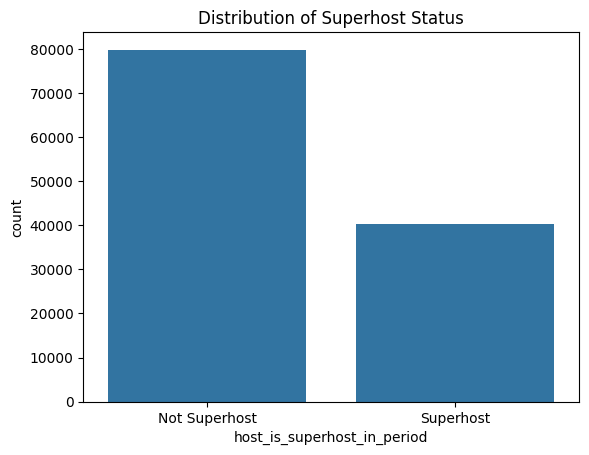

In [35]:
# Superhost status counts
sns.countplot(data=df_model, x='host_is_superhost_in_period')
plt.title("Distribution of Superhost Status")
plt.xticks([0, 1], ['Not Superhost', 'Superhost'])
plt.show()


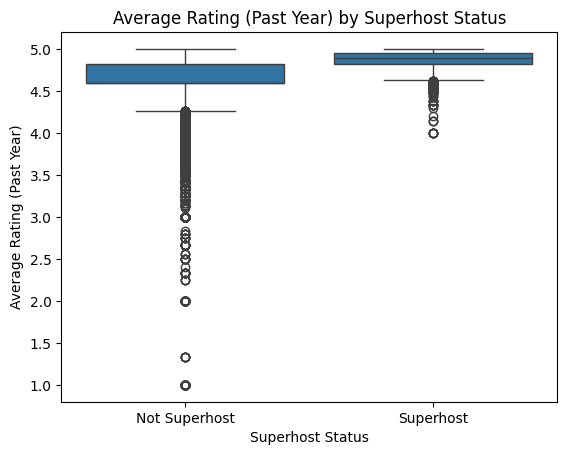

In [36]:
sns.boxplot(data=df_model, x='host_is_superhost_in_period', y='rating_ave_pastYear')
plt.title("Average Rating (Past Year) by Superhost Status")
plt.xticks([0, 1], ['Not Superhost', 'Superhost'])
plt.xlabel("Superhost Status")
plt.ylabel("Average Rating (Past Year)")
plt.show()


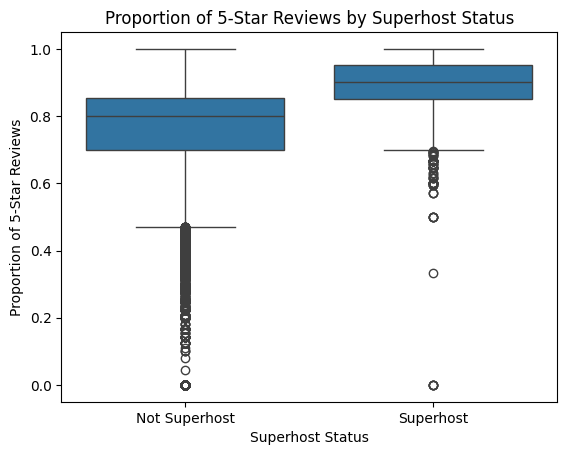

In [37]:
sns.boxplot(data=df_model, x='host_is_superhost_in_period', y='prop_5_StarReviews_pastYear')
plt.title("Proportion of 5-Star Reviews by Superhost Status")
plt.xticks([0, 1], ['Not Superhost', 'Superhost'])
plt.xlabel("Superhost Status")
plt.ylabel("Proportion of 5-Star Reviews")
plt.show()


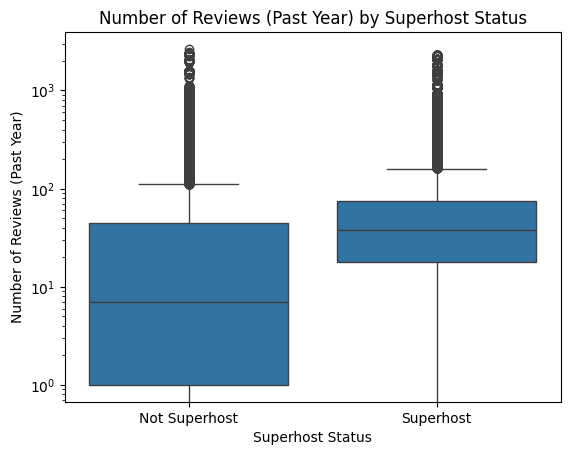

In [38]:
sns.boxplot(data=df_model, x='host_is_superhost_in_period', y='numReviews_pastYear')
plt.title("Number of Reviews (Past Year) by Superhost Status")
plt.xticks([0, 1], ['Not Superhost', 'Superhost'])
plt.xlabel("Superhost Status")
plt.ylabel("Number of Reviews (Past Year)")
plt.yscale('log')  # Log scale in case of long tail
plt.show()


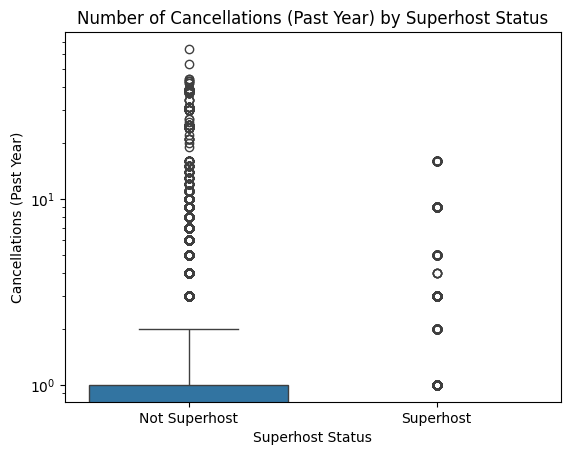

In [39]:
sns.boxplot(data=df_model, x='host_is_superhost_in_period', y='numCancel_pastYear')
plt.title("Number of Cancellations (Past Year) by Superhost Status")
plt.xticks([0, 1], ['Not Superhost', 'Superhost'])
plt.xlabel("Superhost Status")
plt.ylabel("Cancellations (Past Year)")
plt.yscale('log')  # Use log scale if there are big outliers
plt.show()


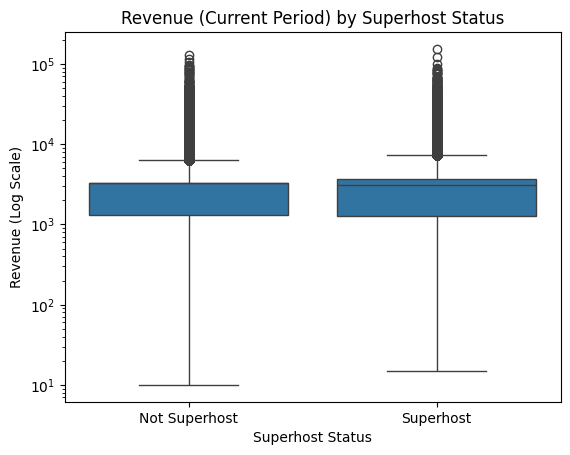

In [40]:
sns.boxplot(data=df_model, x='host_is_superhost_in_period', y='revenue')
plt.title("Revenue (Current Period) by Superhost Status")
plt.xticks([0, 1], ['Not Superhost', 'Superhost'])
plt.xlabel("Superhost Status")
plt.ylabel("Revenue (Log Scale)")
plt.yscale('log')
plt.show()


Revenue alone doesn't guarantee Superhost status

Superhosts are generally more stable earners

But not all high-earning hosts are Superhosts (some could be inconsistent, cancel bookings, etc.)

This makes revenue a supporting feature, not a primary driver

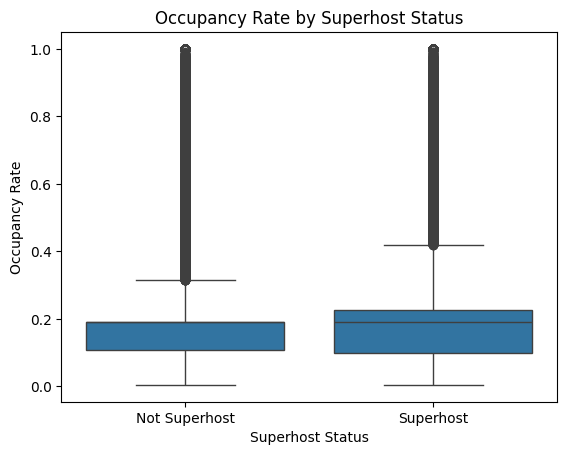

In [41]:
sns.boxplot(data=df_model, x='host_is_superhost_in_period', y='occupancy_rate')
plt.title("Occupancy Rate by Superhost Status")
plt.xticks([0, 1], ['Not Superhost', 'Superhost'])
plt.xlabel("Superhost Status")
plt.ylabel("Occupancy Rate")
plt.show()


In [42]:
# Get correlations with the target variable
correlation = df_model.corr(numeric_only=True)['host_is_superhost_in_period'].sort_values(ascending=False)

# Show top positive and negative correlations
print(correlation)


host_is_superhost_in_period            1.000000
prev_host_is_superhost_in_period       0.759912
tract_superhosts_ratio                 0.431533
rating_ave_pastYear                    0.401462
prop_5_StarReviews_pastYear            0.388437
hostResponseAverage_pastYear           0.232917
Number of Photos                       0.214812
num_5_star_Rev_pastYear                0.115242
Cleaning Fee (USD)                     0.069563
numReviews_pastYear                    0.068396
Bedrooms                               0.061982
Max Guests                             0.060787
Zipcode                                0.045044
revenue                                0.038732
Nightly Rate_tractQuartile             0.029125
occupancy_rate                         0.023675
Instantbook Enabled                    0.020759
Bathrooms                             -0.006555
Airbnb Host ID                        -0.009007
Minimum Stay                          -0.022214
tract_price_variance                  -0

## Modelling

In [48]:
# Target
y = df_model['host_is_superhost_in_period']

# Drop non-predictive / ID columns

X = df_model.drop(columns=[
    'host_is_superhost_in_period',
    'Airbnb Host ID', 'Created Date' # identifier
])

# Encode categorical features (basic one-hot for now)
X = pd.get_dummies(X, drop_first=True)

# Train-test split (stratify by target to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape)


(96136, 174) (24034, 174)


/Users/gitanjalinambiar/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.79      0.85     15975
         1.0       0.67      0.87      0.76      8059

    accuracy                           0.81     24034
   macro avg       0.80      0.83      0.80     24034
weighted avg       0.84      0.81      0.82     24034

ROC-AUC Score: 0.9087003925082252


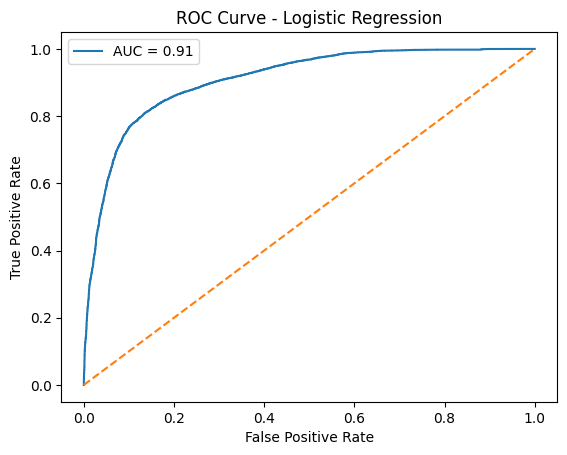

In [49]:
# Train
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg.fit(X_train, y_train)

# Predict
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]

# Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC Score:", roc_auc)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

Classification Report - Random Forest:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     15975
         1.0       0.97      0.96      0.96      8059

    accuracy                           0.98     24034
   macro avg       0.97      0.97      0.97     24034
weighted avg       0.98      0.98      0.98     24034

ROC-AUC Score: 0.9960244060771684


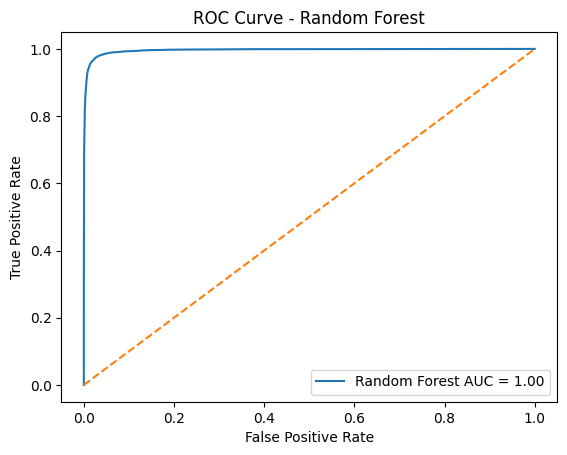

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Train the model
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',  # handles class imbalance
    max_depth=None  # you can tune this later
)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report - Random Forest:")
print(classification_report(y_test, y_pred_rf))

roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
print("ROC-AUC Score:", roc_auc_rf)

# Plot ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest AUC = {roc_auc_rf:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()


##### Feature importance plot

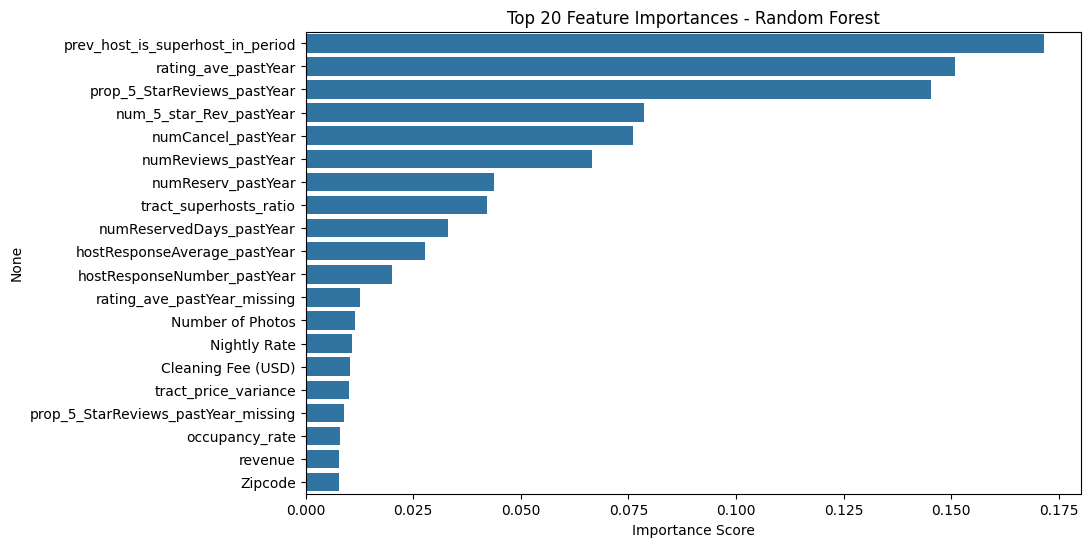

In [51]:
import pandas as pd
import seaborn as sns

# Get top 20 most important features
feat_importance = pd.Series(rf_model.feature_importances_, index=X.columns)
top_feats = feat_importance.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_feats.values, y=top_feats.index)
plt.title("Top 20 Feature Importances - Random Forest")
plt.xlabel("Importance Score")
plt.show()


## Clustering

In [57]:
# Subset only Superhosts
df_superhosts = df_model[df_model['host_is_superhost_in_period'] == 1].copy()

# Define clustering features
superhost_features = [
    'rating_ave_pastYear',
    'prop_5_StarReviews_pastYear',
    'numReviews_pastYear',
    'numCancel_pastYear',
    'revenue',
    'occupancy_rate',
    'hostResponseAverage_pastYear',
    'Number of Photos',
    'Bedrooms',
    'Bathrooms',
    'Cleaning Fee (USD)',
    'Instantbook Enabled',
    'tract_superhosts_ratio'
]


In [58]:
from sklearn.preprocessing import StandardScaler

# Prep data
X_super = df_superhosts[superhost_features].fillna(0)
scaler = StandardScaler()
X_super_scaled = scaler.fit_transform(X_super)


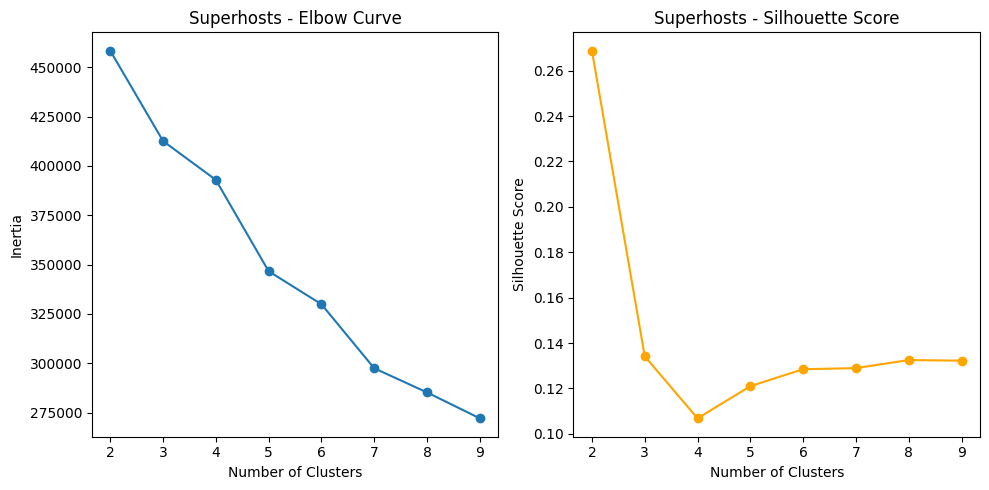

In [59]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

inertia = []
silhouette_scores = []
K = range(2, 10)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_super_scaled)
    inertia.append(km.inertia_)
    silhouette_scores.append(silhouette_score(X_super_scaled, labels))

# Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, marker='o')
plt.title("Superhosts - Elbow Curve")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, marker='o', color='orange')
plt.title("Superhosts - Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()


In [60]:
# Final KMeans for Superhosts with 3 clusters
kmeans_super = KMeans(n_clusters=3, random_state=42)
superhost_clusters = kmeans_super.fit_predict(X_super_scaled)

# Assign cluster labels
df_superhosts['superhost_cluster'] = superhost_clusters


In [61]:
# Compare mean values for each cluster
df_superhosts.groupby('superhost_cluster')[superhost_features].mean().round(2)


,rating_ave_pastYear,prop_5_StarReviews_pastYear,numReviews_pastYear,numCancel_pastYear,revenue,occupancy_rate,hostResponseAverage_pastYear,Number of Photos,Bedrooms,Bathrooms,Cleaning Fee (USD),Instantbook Enabled,tract_superhosts_ratio
superhost_cluster,,,,,,,,,,,,,
0,4.87,0.90,234.08,0.51,8305.96,0.18,99.17,35.05,3.28,2.36,143.35,0.57,0.44
1,4.95,0.95,45.21,0.01,2815.85,0.20,98.72,20.59,1.39,1.17,46.31,0.42,0.46
2,4.80,0.84,95.51,0.02,2716.95,0.20,98.55,19.47,1.34,1.19,47.31,0.51,0.47


0	Power Superhosts	Retain, reward, expand
1	High Quality, Low Volume	Encourage growth, reward quality
2	At-Risk Superhosts	Proactive support, prevent drop-off

In [62]:
# Subset non-superhosts
df_non_superhosts = df_model[df_model['host_is_superhost_in_period'] == 0].copy()

# Same features for consistency
non_superhost_features = superhost_features.copy()


In [63]:
# Prepare and scale
X_non = df_non_superhosts[non_superhost_features].fillna(0)
X_non_scaled = scaler.fit_transform(X_non)  # reuse the scaler if you like


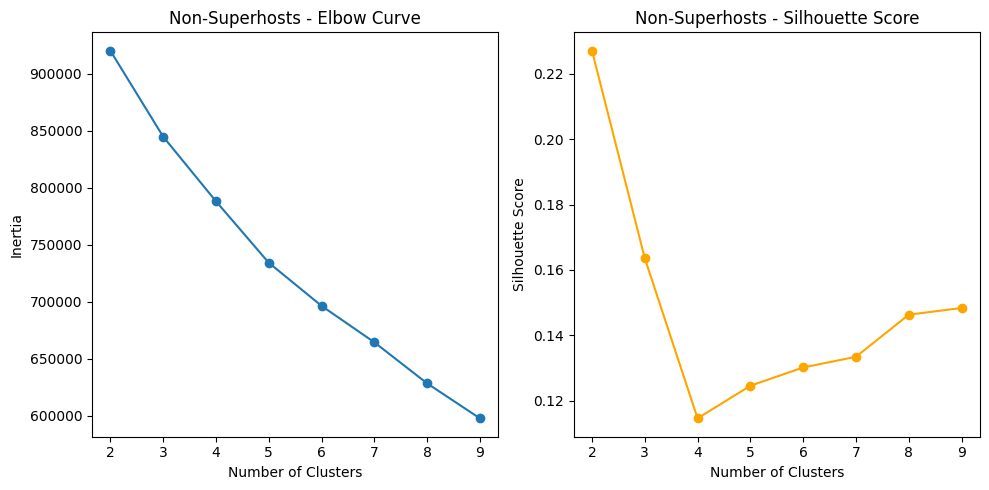

In [64]:
inertia = []
silhouette_scores = []
K = range(2, 10)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_non_scaled)
    inertia.append(km.inertia_)
    silhouette_scores.append(silhouette_score(X_non_scaled, labels))

# Plot it
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, marker='o')
plt.title("Non-Superhosts - Elbow Curve")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, marker='o', color='orange')
plt.title("Non-Superhosts - Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()


In [65]:
# Final KMeans for non-superhosts
kmeans_non = KMeans(n_clusters=3, random_state=42)
non_superhost_clusters = kmeans_non.fit_predict(X_non_scaled)

# Assign cluster labels
df_non_superhosts['non_superhost_cluster'] = non_superhost_clusters


In [66]:
df_non_superhosts.groupby('non_superhost_cluster')[non_superhost_features].mean().round(2)


,rating_ave_pastYear,prop_5_StarReviews_pastYear,numReviews_pastYear,numCancel_pastYear,revenue,occupancy_rate,hostResponseAverage_pastYear,Number of Photos,Bedrooms,Bathrooms,Cleaning Fee (USD),Instantbook Enabled,tract_superhosts_ratio
non_superhost_cluster,,,,,,,,,,,,,
0,4.75,0.84,23.90,0.32,2665.63,0.20,82.02,13.38,1.15,1.16,32.60,0.41,0.27
1,4.69,0.80,103.11,0.99,5725.93,0.18,93.28,27.72,2.78,2.10,124.63,0.51,0.31
2,4.24,0.52,157.12,1.23,2362.54,0.17,94.41,13.75,1.26,1.18,39.25,0.53,0.24


0	Emerging Superhosts	🟢 Promotion + Light nudges
1	Risky but Strong Hosts	🟡 Operational support
2	Quality Concern Power Users	🔴 Quality improvement program